In [2]:
import numpy as np 
import torch 
import pandas as pd 
import h5py
import pickle
import os
import matplotlib.patches as mpatches
from matplotlib import pyplot as plt

/usr/local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data and Model

In [3]:
def h5_to_pd(h5_data, keys):
    data = pd.DataFrame()
    if keys:
        for key in keys:
            if key == 'tag':
                continue
            data[key] = h5_data[key][:]
    else:
        for key in h5_data:
            if key == 'tag':
                continue
            data[key] = h5_data[key][:]
    return data 


In [4]:
train_h5 = h5py.File('./TiktokLarge/train.h5','r')
train_pd = h5_to_pd(train_h5, keys=['uid','item_id'])
print(len(train_pd))

223442979


In [6]:
test_h5 = h5py.File('./TiktokLarge/test.h5','r')
test_pd = h5_to_pd(test_h5, keys=['uid','item_id'])
print(len(test_pd))

27585554


In [5]:
perc = 60
cnt_user_train_pd = train_pd.groupby(['uid']).agg(len)
user_list = list(cnt_user_train_pd[cnt_user_train_pd.item_id>np.percentile(cnt_user_train_pd.item_id,perc)].index)
len(user_list)

224099

In [6]:
cnt_item_train_pd = train_pd.groupby(['item_id']).agg(len)
item_list = list(cnt_item_train_pd[cnt_item_train_pd.uid>np.percentile(cnt_item_train_pd.uid,perc)].index)
len(item_list)

704352

In [7]:
select_user_item = test_pd[
    (test_pd.uid.isin(user_list))&
    (test_pd.item_id.isin(item_list))
][['uid','item_id']].values
len(select_user_item)

21018044

In [9]:
# Load Model
ST_like_model = torch.load('../checkpoints/TiktokLarge/TiktokLarge_like_SharedBottom_rerun/TiktokLarge/SharedBottom_TiktokLarge_like_001_c8a9398c.model',
                           map_location='cpu')
ST_finish_model = torch.load('../checkpoints/TiktokLarge/TiktokLarge_finish_SharedBottom_rerun/TiktokLarge/SharedBottom_TiktokLarge_finish_001_d04de58c.model',
                           map_location='cpu')
MMoE_model = torch.load('../checkpoints/TiktokLarge/TiktokLarge_MMoE_rerun/TiktokLarge/MMoE_TiktokLarge_001_22b09b73.model',
                           map_location='cpu')
PLE_model = torch.load('../checkpoints/TiktokLarge/TiktokLarge_PLE_rerun/TiktokLarge/PLE_TiktokLarge_003_ed9ed356.model',
                           map_location='cpu')
STEM_model = torch.load('../checkpoints/TiktokLarge/TiktokLarge_STEM_rerun/TiktokLarge/STEM_TiktokLarge_001_b08037c0.model',
                           map_location='cpu')
ME_MMoE_model = torch.load('../checkpoints/TiktokLarge/TiktokLarge_MMoE_ME_rerun/TiktokLarge/MMoE_ME_TiktokLarge_001_3be9e5e0.model',
                           map_location='cpu')
ME_PLE_model = torch.load('../checkpoints/TiktokLarge/TiktokLarge_PLE_ME_rerun/TiktokLarge/PLE_ME_TiktokLarge_001_ae1595a5.model',
                           map_location='cpu')

In [10]:
def get_model_embedding(model):
    uid_embeddings = model['embedding_layer.embedding_layer.embedding_layers.uid.weight'] 
    iid_embeddings = model['embedding_layer.embedding_layer.embedding_layers.item_id.weight']
    return {
        'uid_embeddings':uid_embeddings,
        'iid_embeddings':iid_embeddings
    }

def get_stem_embedding(stem_model):
    uid_embeddings = stem_model['embedding_layer.embedding_layer.embedding_layers.uid.weight']
    iid_embeddings = stem_model['embedding_layer.embedding_layer.embedding_layers.item_id.weight']
    embedding_dim = uid_embeddings.shape[1]//3
    
    task1_uid_emb = uid_embeddings[:,:embedding_dim]
    task1_iid_emb = iid_embeddings[:,:embedding_dim]
    
    task2_uid_emb = uid_embeddings[:,embedding_dim:embedding_dim*2]
    task2_iid_emb = iid_embeddings[:,embedding_dim:embedding_dim*2]

    task_shared_uid_emb = uid_embeddings[:,embedding_dim*2:]
    task_shared_iid_emb = iid_embeddings[:,embedding_dim*2:]

    return {
        'task1_uid_emb': task1_uid_emb,
        'task1_iid_emb': task1_iid_emb,
        'task2_uid_emb': task2_uid_emb,
        'task2_iid_emb': task2_iid_emb,
        'task_shared_uid_emb': task_shared_uid_emb,
        'task_shared_iid_emb': task_shared_iid_emb
    }
def get_sim_list(user_item_pair, uembs,iembs):
    tensor_user_item_pair = torch.tensor(user_item_pair)
    print(uembs.shape)
    uemb = torch.index_select(uembs,index=tensor_user_item_pair[:,0],dim=0)
    iemb = torch.index_select(iembs,index=tensor_user_item_pair[:,1],dim=0)
    sim_list = torch.norm(uemb-iemb,dim=1,p=2)
    return sim_list
        

In [11]:
ST_like_emb = get_model_embedding(ST_like_model)
ST_like_emb_sim_list = get_sim_list(select_user_item, ST_like_emb['uid_embeddings'], ST_like_emb['iid_embeddings'])
del ST_like_emb # for saving memory

torch.Size([560264, 16])


In [12]:
len(ST_like_emb_sim_list)/len(test_pd)

0.7619221277919596

In [13]:
ST_finish_emb = get_model_embedding(ST_finish_model)
ST_finish_emb_sim_list = get_sim_list(select_user_item, ST_finish_emb['uid_embeddings'], ST_finish_emb['iid_embeddings'])
del ST_finish_emb

torch.Size([560264, 16])


In [14]:
MMoE_emb = get_model_embedding(MMoE_model)
MMoE_emb_sim_list = get_sim_list(select_user_item, MMoE_emb['uid_embeddings'], MMoE_emb['iid_embeddings'])
del MMoE_emb

torch.Size([560264, 16])


In [15]:
PLE_emb = get_model_embedding(PLE_model)
PLE_emb_sim_list = get_sim_list(select_user_item, PLE_emb['uid_embeddings'], PLE_emb['iid_embeddings'])
del PLE_emb

torch.Size([560264, 16])


In [16]:
STEM_emb = get_stem_embedding(STEM_model)
STEM_task1_emb_sim_list = get_sim_list(select_user_item, STEM_emb['task1_uid_emb'], STEM_emb['task1_iid_emb'])
STEM_task2_emb_sim_list = get_sim_list(select_user_item, STEM_emb['task2_uid_emb'], STEM_emb['task2_iid_emb'])
STEM_shared_emb_sim_list = get_sim_list(select_user_item, STEM_emb['task_shared_uid_emb'], STEM_emb['task_shared_iid_emb'])
del STEM_emb

torch.Size([560264, 16])
torch.Size([560264, 16])
torch.Size([560264, 16])


In [17]:
ME_MMoEemb = get_stem_embedding(ME_MMoE_model)
MEMMoE_task1_emb_sim_list = get_sim_list(select_user_item, ME_MMoEemb['task1_uid_emb'], ME_MMoEemb['task1_iid_emb'])
MEMMoE_task2_emb_sim_list = get_sim_list(select_user_item, ME_MMoEemb['task2_uid_emb'], ME_MMoEemb['task2_iid_emb'])
MEMMoE_shared_emb_sim_list = get_sim_list(select_user_item, ME_MMoEemb['task_shared_uid_emb'], ME_MMoEemb['task_shared_iid_emb'])
del ME_MMoEemb

torch.Size([560264, 42])
torch.Size([560264, 42])
torch.Size([560264, 44])


In [18]:
ME_PLEemb = get_stem_embedding(ME_PLE_model)
MEPLE_task1_emb_sim_list = get_sim_list(select_user_item, ME_PLEemb['task1_uid_emb'], ME_PLEemb['task1_iid_emb'])
MEPLE_task2_emb_sim_list = get_sim_list(select_user_item, ME_PLEemb['task2_uid_emb'], ME_PLEemb['task2_iid_emb'])
MEPLE_shared_emb_sim_list = get_sim_list(select_user_item, ME_PLEemb['task_shared_uid_emb'], ME_PLEemb['task_shared_iid_emb'])
del ME_PLEemb

torch.Size([560264, 16])
torch.Size([560264, 16])
torch.Size([560264, 16])


In [19]:
similarity = pd.DataFrame({
    'uid':select_user_item[:,0],
    'item_id':select_user_item[:,1],
    'ST_like':ST_like_emb_sim_list,
    'ST_finish': ST_finish_emb_sim_list,
    'MMoE': MMoE_emb_sim_list,
    'PLE': PLE_emb_sim_list,
    'STEM_finish': STEM_task1_emb_sim_list,
    'STEM_like': STEM_task2_emb_sim_list,
    'STEM_shared': STEM_shared_emb_sim_list,
    'ME_MMoE_finish':  MEMMoE_task1_emb_sim_list,
    'ME_MMoE_like': MEMMoE_task2_emb_sim_list,
    'ME_MMoE_shared': MEMMoE_shared_emb_sim_list,
    'ME_PLE_finish':  MEPLE_task1_emb_sim_list,
    'ME_PLE_like': MEPLE_task2_emb_sim_list,
    'ME_PLE_shared': MEPLE_shared_emb_sim_list
})


In [7]:
# Save the similarity dataframe from local path.
# with open('./cross_task_similarity_60.pkl','wb') as f:
#     pickle.dump(similarity, f)

# # Load the similarity dataframe from local path.
with open('./cross_task_similarity_60.pkl','rb') as f:
    similarity = pickle.load(f)

In [8]:
# Define and produce the conflict subset
def produce_conflict_subset_and_cal_sim(mode=0):
    if mode ==0:
        ## Finish<=40-percentile and Like> 60-percentile
        finish_quant=40
        like_quant=60

        ST_like_threshold = np.percentile(similarity['ST_like'], like_quant)
        ST_finish_threshold = np.percentile(similarity['ST_finish'], finish_quant)
        print(ST_like_threshold,ST_finish_threshold)

        select_index =   (similarity['ST_like']>ST_like_threshold)&\
            (similarity['ST_finish']<=ST_finish_threshold)
        cut_similarity = similarity[select_index]
        exclude_similarity = similarity[~select_index]
    elif mode ==1:
        ## Finish>60-percentile and Like<= 40-percentile
        finish_quant=60
        like_quant=40

        ST_like_threshold = np.percentile(similarity['ST_like'], like_quant)
        ST_finish_threshold = np.percentile(similarity['ST_finish'], finish_quant)
        print(ST_like_threshold,ST_finish_threshold)

        select_index =   (similarity['ST_like']<=ST_like_threshold)&\
            (similarity['ST_finish']>ST_finish_threshold)
        cut_similarity = similarity[select_index]
        exclude_similarity = similarity[~select_index]
    else:
        raise NotImplementedError
    
    return cut_similarity, exclude_similarity

mode=0
cut_similarity, exclude_similarity = produce_conflict_subset_and_cal_sim(mode=mode)

0.25186892747879025 0.26338476538658145


In [38]:
len(cut_similarity)/len(test_pd)

0.11128001996987263

In [64]:
# Detailed Implements of plotting distance distribution.
import matplotlib.ticker as mticker
import numpy as np


def plot_multitask(col,title,splits):

    sim_all_bins = pd.cut(similarity[col], splits,include_lowest=True).value_counts()  # 等距分桶
    thred = []
    for i in sim_all_bins.index:
        thred.append(i.left)
        thred.append(i.right)
    threds = np.sort(np.array(list(set(thred))))

    sim_select_bins = pd.cut(cut_similarity[col], bins=threds,include_lowest=True).value_counts().sort_index().reset_index(drop=True)
    sim_non_select_bins = pd.cut(exclude_similarity[col], bins=threds,include_lowest=True).value_counts().sort_index().reset_index(drop=True)

    low_thre, high_thre = np.percentile(similarity[col],40),np.percentile(similarity[col],60)
    colors = []
    for i, t in enumerate(threds[:-1]):
        if t < low_thre:
            colors.append('#58A658')
        elif t > high_thre or (t < high_thre and threds[i+1] > high_thre):
            colors.append('#ED8C3D')
        else:
            colors.append('#4E84B5')

    
    fig, ax = plt.subplots(figsize=(5.5,3))
    select_bars = plt.bar(sim_select_bins.index, sim_select_bins, edgecolor='k', color=colors)
    exclude_bars = plt.bar(sim_non_select_bins.index,sim_non_select_bins, bottom=sim_select_bins,color='white',edgecolor=colors,hatch='/')

    if title:
        plt.title(title)

    mid_patch = mpatches.Patch(color='#4E84B5', label='Middle - 20%')
    low_patch = mpatches.Patch(color='#58A658', label='Bottom - 40%')
    high_patch = mpatches.Patch(color='#ED8C3D', label='Top - 40%')

    plt.xlabel(r'Bin index',fontsize=12)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylabel("Frequency",fontsize=12)
    plt.legend(handles=[low_patch,mid_patch, high_patch],frameon=False,fontsize=12)
    plt.tick_params(axis='y', which='major', labelsize=12)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.yaxis.offsetText.set_fontsize(12)

    # plt.tick_params(axis='both', which='major', labelsize=12)

In [11]:
path = './embedding_analysis/'
if not os.path.exists(path):
    os.makedirs(path)

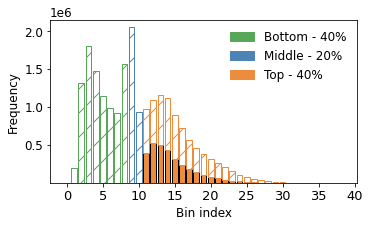

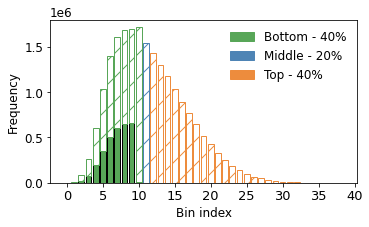

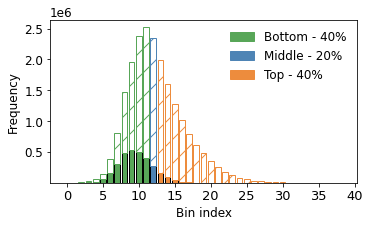

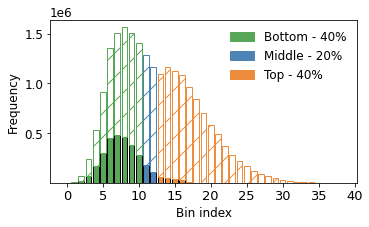

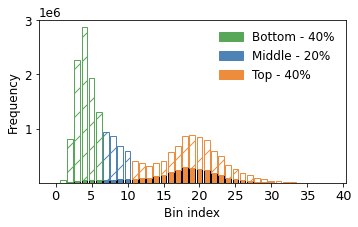

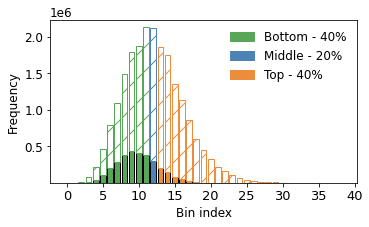

In [66]:

for col in ['ST_like', 'ST_finish', 'PLE', 'STEM_finish',\
       'STEM_like', 'STEM_shared']:
   #  plt.figure(figsize=(5.5,3))
    plot_multitask(col,None,39)
    plt.savefig('{}emb_dis_{}_{}.pdf'.format(path,col,mode),dpi=500,bbox_inches='tight')
    
    plt.show()